## SAMRO Artist Radio-Activity Dashboard pre-processing and testing

## Import relevant packages for preprocessing

In [147]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from adtk.detector import SeasonalAD
from adtk.data import validate_series


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## import CSV file and output data

In [11]:
data_original = pd.read_excel("Black Coffee - 2020.xlsx")
data = data_original.copy()
data.head()

,Station,Artist,Title,Imp's,Sec,Date/time
0,North West FM,Black Coffee feat. Nakhane Toure,We Dance Again,"21,000",0,01 Jan 2020 - 00:07
1,MFM,Black Coffee feat. Shekhinah,Your Eyes,0,0,01 Jan 2020 - 00:08
2,947,Black Coffee & David Guetta feat. Delilah Montagu,Drive,"11,000",180,01 Jan 2020 - 00:35
3,Eldos FM,Black Coffee feat. Soulstar,You Rock My World,0,0,01 Jan 2020 - 00:39
4,YFM 99.2,Black Coffee feat. Zhao,Any Other Way,"29,000",0,01 Jan 2020 - 00:50


## Pre-processing of data

In [12]:
# Remove leading white spce
for x in data.columns:
    data.rename(columns={x:x.strip()}, inplace=True)

#rename columns to make it easier to read
data.rename(columns={"Imp's": 'Impacts', 'Date/time': 'Date'}, inplace=True)

# remove all channels where impacts = 0 as they are assumed not to have official RAMS figures
data = data[data.Impacts != 0]

#convert date column to a date object to enable Time Series analysis
data['Date']= pd.to_datetime(data['Date'])

#Sort columns by date
data.sort_values(by='Date', inplace=True)

#Convert Impacts into numeric format
data['Impacts'] = data['Impacts'].str.replace(',','')
data['Impacts'] = data['Impacts'].str.extract('(\d+)', expand=False) # remove all non-numeric characters
data['Impacts'] = data['Impacts'].map(lambda x: pd.to_numeric(x)) #convert to integer

# Fill null values and inf values with 0
data['Impacts'].fillna(0, inplace = True)
data.replace([np.inf, -np.inf], 0, inplace=True)

#convert 'Seconds' and 'Impacts' columns to integer types
data["Sec"] = pd.to_numeric(data["Sec"])
data['Impacts'] = data['Impacts'].astype('int64')

#Get rid of rows that dont make sense ie where there are no second of play but have > 0 impacts
#this could be because of incorrect data capture or under 1 second of play is recorded
data = data[~((data["Impacts"] > 0) & (data["Sec"] == 0))]

## Exploratory code

In [13]:
#count number of unique Radio Stations tracked
data.Station.nunique()

43

In [14]:
# Check overview of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8970 entries, 2 to 22716
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Station  8970 non-null   object        
 1   Artist   8970 non-null   object        
 2   Title    8970 non-null   object        
 3   Impacts  8970 non-null   int64         
 4   Sec      8970 non-null   int64         
 5   Date     8970 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 490.5+ KB


In [15]:
#Get basic summary statistics of dataset
data.describe()

,Impacts,Sec
count,8970.000000,8970.000000
mean,138217.505463,249.258194
std,157437.301387,93.966489
min,0.000000,0.000000
25%,20000.000000,180.000000
50%,79333.000000,240.000000
75%,203000.000000,312.000000
max,998000.000000,972.000000


In [16]:
# Check date ranges of data, since it is one full year we will not need to subset it
print (data.Date.min())
print (data.Date.max())

2020-01-01 00:35:00
2020-12-31 23:08:00


In [17]:
original_data = data.copy() #make a copy of the pre-processed data as a backup
data.tail()

,Station,Artist,Title,Impacts,Sec,Date
22705,Munghana Lonene FM,Black Coffee feat. Sabrina Claudio,Sbcnscsly,584000,432,2020-12-31 19:44:00
22706,Ligwalagwala FM,Black Coffee feat. Sabrina Claudio,Sbcnscsly,348000,354,2020-12-31 20:16:00
22708,Jacaranda,Black Coffee feat. Usher,LaLaLa,233000,204,2020-12-31 20:31:00
22714,KFM,Black Coffee feat. Nakhane Toure,We Dance Again,212000,324,2020-12-31 22:09:00
22716,SAfm,Black Coffee feat. Nakhane Toure,We Dance Again,13000,330,2020-12-31 23:08:00


## Check for a normal distribution


Kurtosis: Impacts    3.768057
dtype: float64
Skewness: Impacts    1.763089
dtype: float64
Shapiro-Wilkes: Statistic: 0.808011531829834, p-value = 0.0


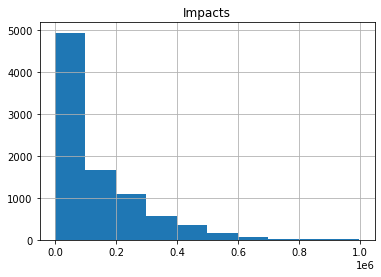

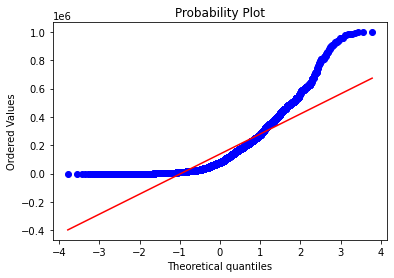

In [18]:
# Check for normality of dataframe for 'Impacts'

# Mean () and Median () not close together
dt = data[['Impacts']]
print(f'Kurtosis: {dt.kurt()}')
print(f'Skewness: {dt.skew()}')

# Do a Shapiro Wilkes test
stat, p = shapiro(dt.iloc[:,:].values)
print(f'Shapiro-Wilkes: Statistic: {stat}, p-value = {p}')

data.hist('Impacts')
plt.show()

#Create a QQ plot to check for normal distribution
stats.probplot(data['Impacts'], dist="norm", plot=pylab)
pylab.show()



Kurtosis: Sec    4.473664
dtype: float64
Skewness: Sec    1.057147
dtype: float64
Shapiro-Wilkes: Statistic: 0.935672402381897, p-value = 0.0


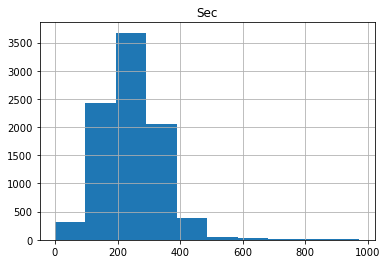

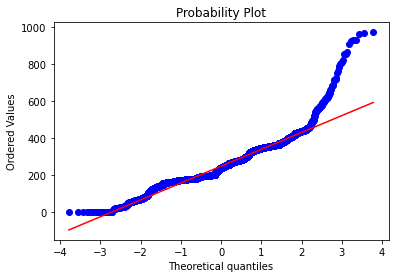

In [19]:
# Check for normality of dataframe for 'seconds'
# Mean (249) and Median (240) are close together
# Data looks like it follows a normal distribution
d = data[['Sec']]
print(f'Kurtosis: {d.kurt()}')
print(f'Skewness: {d.skew()}')

# Do a Shapiro Wilkes test
statd, pd = shapiro(d)
print(f'Shapiro-Wilkes: Statistic: {statd}, p-value = {pd}')

data.hist('Sec')
plt.show()

#Create a QQ plot to check for normal distribution
stats.probplot(data['Sec'], dist="norm", plot=pylab)
pylab.show()

It seems that 'Impacts' does not follow a normal distribution and is skewed right. 'Secs' is very slightly skewed right but resembles a normal distribution. The Quantile Quantile plot (QQ) of the 'Secs' variable show that it is close to a normal distribution. I will assume as such.

## Use Bartlett's test to test for change in variance before and after lockdown and album launch


In [20]:
# Split data into two datasets, to check seconds played data before and after the release of Black Coffee's album SBCNCSLY
# Release date: 1 May 2020

PA = data[['Sec', 'Date']]
PreAlbum = PA[PA['Date'] < '2020-05-01']

PostAlbum = PA[PA['Date'] >= '2020-05-01']

#Remove Date component to check for variance of Seconds played values within timeframe

PreAlbumSec = PreAlbum['Sec']
PostAlbumSec = PostAlbum['Sec']


In [21]:
PreAlbumSec.describe()

count    2118.000000
mean      224.059490
std        87.013311
min         0.000000
25%       180.000000
50%       198.000000
75%       264.000000
max       930.000000
Name: Sec, dtype: float64

In [22]:
PostAlbumSec.describe()

count    6852.000000
mean      257.047285
std        94.672360
min         0.000000
25%       180.000000
50%       252.000000
75%       330.000000
max       972.000000
Name: Sec, dtype: float64

In [23]:
# Do Bartlett's test to check significance of variance between two groups
stats.bartlett(PreAlbumSec, PostAlbumSec)

BartlettResult(statistic=22.328772996158293, pvalue=2.297384464247441e-06)

Since p value is less than 0.05 there is evidence that the the change in variance is significant after the release of his album release in 2020

In [24]:
#bartletts test for equal variance before and after the first lockdown date that started on 26 March 2020

PreLockdown = PA[PA['Date'] < '2020-03-26']

PostLockdown = PA[PA['Date'] >= '2020-03-26']
PostAlbum.head()

#Remove Date component to check for variance of Seconds played values within timeframe

PreLockdownSec = PreLockdown['Sec']
PostLockdownSec = PostLockdown['Sec']
# Do Bartlett's test to check significance of variance between two groups
stats.bartlett(PreLockdownSec, PostLockdownSec)


BartlettResult(statistic=66.36816061913828, pvalue=3.740962870588646e-16)

Since p value is less than 0.05 there is evidence that the the change in variance is significant after the lockdown started.

## T-Test for change in means after lockdown

Do a t-test to test for significance of means before and after the lockdown started on Black Coffee's seconds of play

$H_{0}$: Lockdown had no effect on Black Coffee's spins after lockdown was announced 

$H_{1}$: Lockdown had an effect on Black Coffee's spins after lockdown was announced

In [25]:
from scipy import stats

t_value,p_value=stats.ttest_ind(PreLockdownSec,PostLockdownSec)

print('Test statistic is %f'%float("{:.6f}".format(t_value)))

print('p-value for two tailed test is %f'%p_value)

alpha = 0.05


Test statistic is -13.814048
p-value for two tailed test is 0.000000


The p value is less than 0.05 therefore we reject the null hypothesis. Therefore lockdown Black Coffee's spins changed significantly after the lockdown date. This will need to be analysed as its possible that spins did not change due to lockdown, there could have been other factors.

In [26]:
# Export data to CSV for use in Tableau
data.to_csv('BlackCoffee_Cleaned_dataset.csv')

## Time series analysis of Secs


In [27]:
# create a new data set to do a basic TS analysis for Seconds

df = data[['Sec', 'Date']]
df.head()


,Sec,Date
2,180,2020-01-01 00:35:00
5,216,2020-01-01 00:56:00
6,198,2020-01-01 00:57:00
12,198,2020-01-01 04:39:00
15,66,2020-01-01 05:08:00


In [28]:
#use the time variable as the new index to the dataframe and drop it from the main axis if necessary

df.set_index('Date', inplace = True) 

df

,Sec
Date,
2020-01-01 00:35:00,180
2020-01-01 00:56:00,216
2020-01-01 00:57:00,198
2020-01-01 04:39:00,198
2020-01-01 05:08:00,66
...,...
2020-12-31 19:44:00,432
2020-12-31 20:16:00,354
2020-12-31 20:31:00,204


In [29]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8970 entries, 2020-01-01 00:35:00 to 2020-12-31 23:08:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sec     8970 non-null   int64
dtypes: int64(1)
memory usage: 140.2 KB


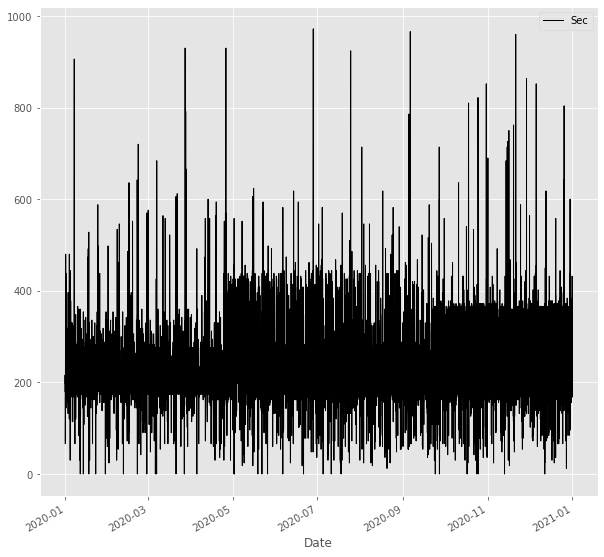

In [30]:
#plot the series
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(10,10)
df.plot(linewidth=1, color='black')
plt.show()

In [32]:
# produce a multiplicative and additive decomposition of the series 

sdc_a = seasonal_decompose(dfsum, model='a') # this is the model-parameter's default setting
sdc_m = seasonal_decompose(dfsum, model='m')

additive_model = sdc_a.trend+sdc_a.seasonal # deterministic part of this decomposition
multiplicative_model = sdc_m.trend*sdc_m.seasonal

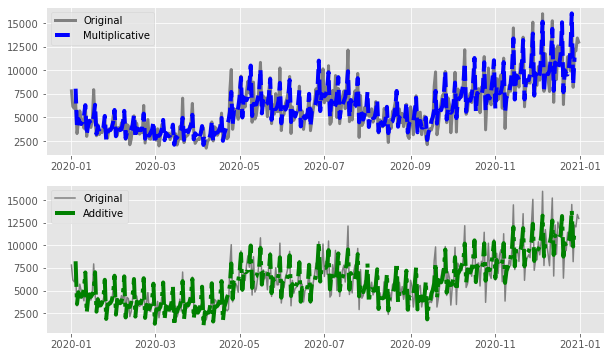

In [33]:
#Plot the different seasonal models

plt.rcParams['figure.figsize']=(10,6)
plt.style.use('ggplot')
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(dfsum, label = 'Original', color='grey',linewidth=3)
plt.plot(multiplicative_model, label = 'Multiplicative',linestyle='--',color='blue', linewidth=4)
plt.legend(loc = 'best')
plt.subplot(2,1,2)
plt.plot(dfsum, label = 'Original',color='grey')
plt.plot(additive_model, label = 'Additive',linestyle='-.', color='green', linewidth=4)
plt.legend(loc = 'best')
plt.show()

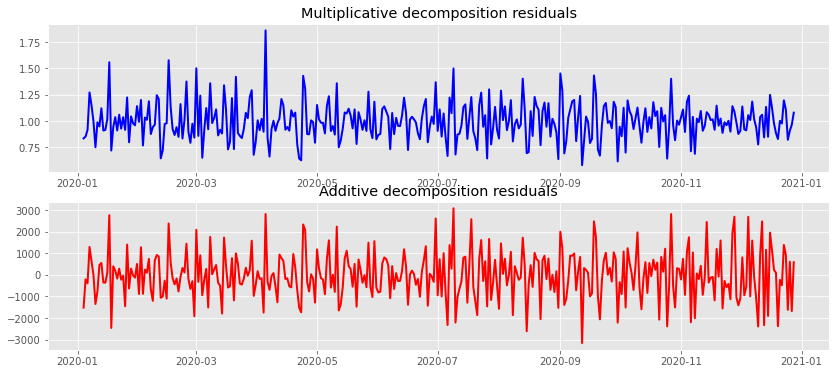

In [34]:
#plot the two decomposition residuals
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(14,6)
x = dfsum.index
residual_m = sdc_m.resid
plt.subplot(2,1,1)
plt.title('Multiplicative decomposition residuals')
plt.plot(x, residual_m, 'b', linewidth=2)
residual_a = sdc_a.resid
plt.subplot(2,1,2)
plt.title('Additive decomposition residuals')
plt.plot(x, residual_a, 'r', linewidth=2)
plt.show()

In [35]:
# use the multiplicative model as variance is smaller
# Take the log of the multiplicative model
df_log = np.log(dfsum)

### Acf Plot

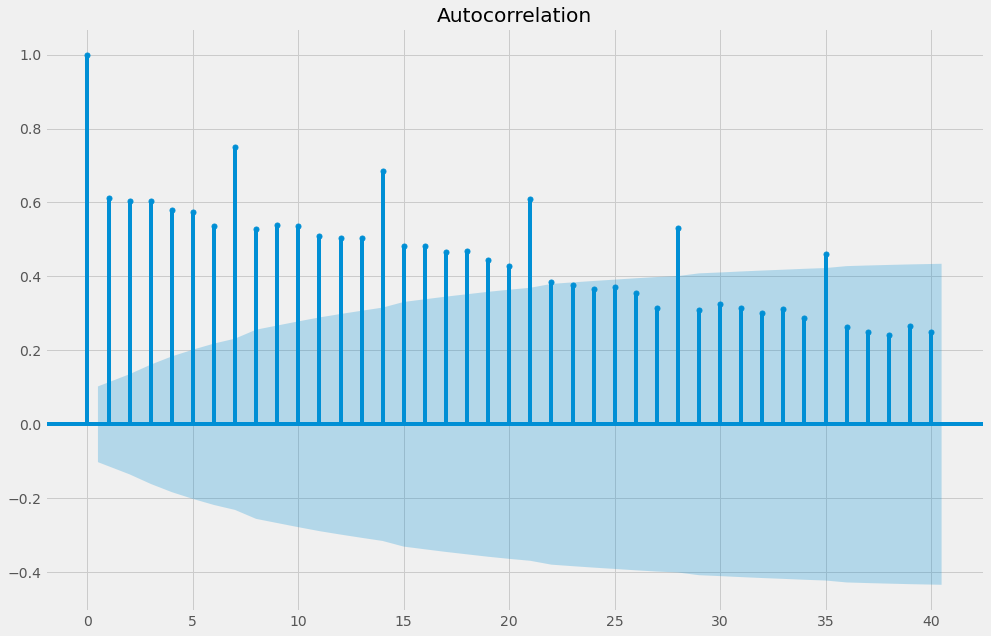

In [36]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(15,10)
plot_acf(df_log,lags=40)
plt.show()

There is clearly a seasonal component every Saturday. This could mean that stations are playing Black Coffee's tracks for a longer time period on saturday's and more regularly.

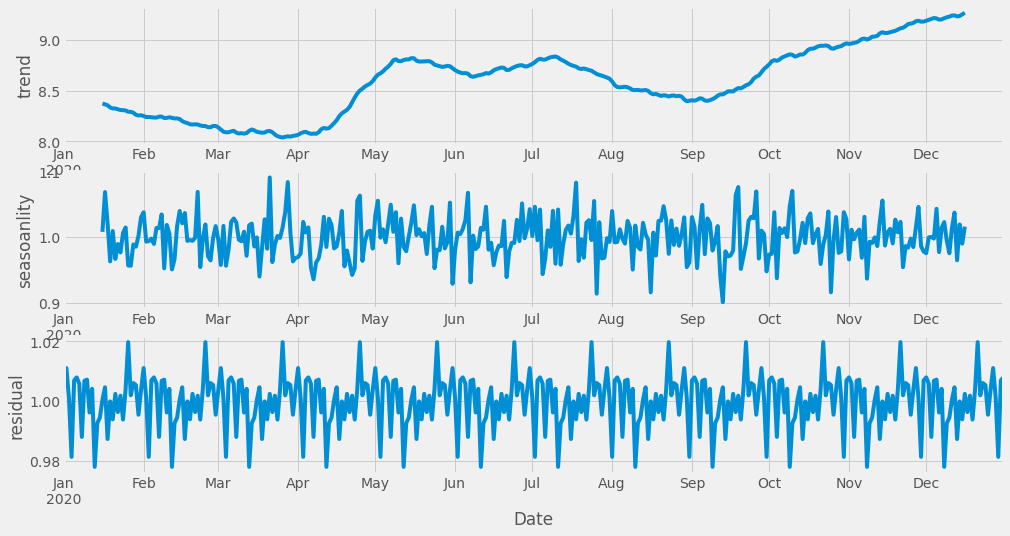

In [37]:
# Decompose series into its trend and seasonal parts

res = seasonal_decompose(df_log, model = "multiplicative",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

    There seems to be a clear upward trend and some seasonality, this can be investigated further if needed.

## Outlier detection

In [112]:
# Create a datafram to check for outliers
df2 = data[['Sec', 'Date']]
df2.rename(columns={ "Date": "ds", "Sec": "y"}, inplace=True)
df2.set_index('ds', inplace = True)
#
#df2.resample('D').sum()
#df2['ds']= pd.to_datetime(df2['ds'])
df2sum = df2.resample('D').sum()
df2sum.reset_index(inplace=True)
df2sum


,ds,y
0,2020-01-01,7818
1,2020-01-02,6156
2,2020-01-03,5958
3,2020-01-04,6714
4,2020-01-05,3294
...,...,...
361,2020-12-27,8190
362,2020-12-28,12228
363,2020-12-29,12042
364,2020-12-30,13410


Initial log joint probability = -18.6621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       559.264    0.00339809       80.1847    3.42e-05       0.001      117  LS failed, Hessian reset 
      99       559.598   0.000509851        68.016       0.616       0.616      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       559.676    1.0711e-06       71.3944      0.5954      0.5954      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       559.678   7.81549e-06       72.4875   9.793e-08       0.001      333  LS failed, Hessian reset 
     293        559.68   2.03671e-09        78.184    0.001314           1      459   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Displaying Prophet plot


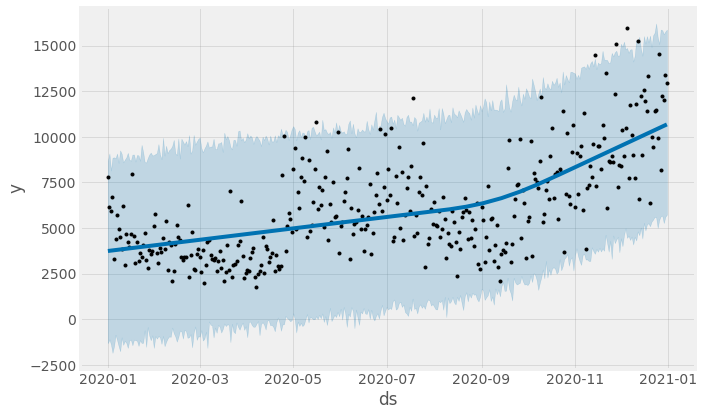

In [119]:
#create a plot to show outliers above the 99 percent confidence interval for predicted means
from fbprophet import Prophet
import altair as alt
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
# Display outputs    
pred = fit_predict_model(df2sum)

In [120]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)


In [118]:
#create a list of anomalies that lie outside the 99 percent confidence interval
anoms = pred[pred.anomaly == 1]
anoms

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
129,2020-05-09,5062.055836,5062.055836,-150.786232,9701.056949,9990,1,0.028923
136,2020-05-16,5133.561341,5133.561341,512.659916,10505.086482,10830,1,0.030001
199,2020-07-18,5777.110851,5777.110851,771.365815,11065.441282,12138,1,0.088364
318,2020-11-14,8841.654228,8841.654228,3224.100983,14414.595445,14478,1,0.004379
332,2020-11-28,9389.481523,9389.481523,4085.983047,14380.998292,15090,1,0.046985
339,2020-12-05,9663.395170,9663.395170,4436.628083,14913.172874,15978,1,0.066643
346,2020-12-12,9937.308817,9937.308817,5282.605199,15082.600278,15234,1,0.009938


In [155]:
#Check for which day of the week the outliers sit: 0 = Monday, 1 = Tues etc
s = anoms.ds
s.dt.dayofweek

129    5
136    5
199    5
318    5
332    5
339    5
346    5
Name: ds, dtype: int64

All outliers occur on a Friday, this could be because of there is more and longer play of Black Coffee's music on the start of the weekend, or there could be more party related radio shows on that day